<h1 style='color: #fca311'>rugby</h1>

In rugby circles, there is the perception that rugby union is more accommodating of a range of different body types and that the body types in rugby league are more homogenous, almost to the point where a winger may be just as big as a prop. To answer this question, I focused on professional rugby players in Australia who come from either the National Rugby League (NRL/League) or Super Rugby AU (Union). I used Python to scrape the player data from both of these organisations' websites and saved it to sqlite. The NRL dataset contains 506 records and the Super Rugby dataset contains 205 records.
In this workbook I will conduct my analysis. Written on the 8th of September 2020. Some commentary may be date specific.

In [1]:
import pandas as pd
import re
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch

%matplotlib notebook

<h2 style='color: #e63946'>loading in data</h2>

In [2]:
conn = sqlite3.connect('rugby.sqlite')
df_league = pd.read_sql('SELECT * FROM nrl', con=conn)
df_union = pd.read_sql('SELECT * FROM super_rugby_au', con=conn)

conn.close()

df_league.head()

,id,name,position,height,weight,dob,birth_place,debut_club,debut_date,previous_club,junior_club,career_appearances,career_tries,current_team
0,1,Alex Glenn,Captain - 2nd Row,182 cm,103 kg,31 July 1988,"Auckland, NZ",Brisbane Broncos,31 July 1988,-,"Northcote Tigers, NZ",264,56,Brisbane Broncos
1,2,Ben Te'o,2nd Row,189 cm,106 kg,27 January 1987,-,Wests Tigers,27 January 1987,"Wests Tigers, South Sydney Rabbitohs",-,165,43,Brisbane Broncos
2,3,David Fifita,2nd Row,186 cm,107 kg,25 February 2000,"Brisbane, QLD",Brisbane Broncos,25 February 2000,-,Souths Acacia Ridge,42,12,Brisbane Broncos
3,4,Ethan Bullemor,Prop,-,-,-,-,Brisbane Broncos,-,None,None,7,0,Brisbane Broncos
4,5,Issac Luke,Hooker,175 cm,93 kg,29 May 1987,"Hawera, NZ",South Sydney Rabbitohs,29 May 1987,"South Sydney Rabbitohs, New Zealand Warriors, ...",-,283,50,Brisbane Broncos


In [3]:
df_union.head()

,id,name,position,height,weight,dob,club
0,1,Robbie Abel,Hooker,183cm,108kg,4 July 1989,NSW Waratahs
1,2,Kurtley Beale,Utility Back,184cm,92kg,6 January 1989,NSW Waratahs
2,3,Gus Bell,Prop,192cm,118kg,4 October 2000,NSW Waratahs
3,4,Cameron Clark,Winger,185cm,88kg,20 March 1993,NSW Waratahs
4,5,Joe Cotton,Hooker,186cm,105kg,12 May 1999,NSW Waratahs


<h2 style='color: #e63946'>cleaning</h2>

<h3 style='color: #457b9d'>age</h3>

Calculating age in years from date of birth.

In [4]:
# League
df_league.dob = df_league.dob.map(lambda x: None if x == '-' else x)

# Setting now to current time
now = pd.Timestamp('now')
# Format of dobs in dataframes
my_format = '%d %B %Y'

df_league.dob = pd.to_datetime(df_league.dob, format=my_format)
df_league['age'] = (now - df_league.dob).astype('<m8[Y]')

# Union
df_union.dob = pd.to_datetime(df_union.dob, format=my_format)
df_union['age'] = (now - df_union.dob).astype('<m8[Y]')

<h3 style='color: #457b9d'>height & weight</h3>

Extracting the height and weight as an integer from the text field.

In [5]:
def find_height_weight(x):
    """Extracts height or weight from a string"""
    if type(x) == str:
        found = re.findall('[0-9]{2,3}', x)
        if len(found) == 0:
            return None
        return int(found[0])
    return x

# Mapping the function
df_league.height = df_league.height.map(find_height_weight)
df_league.weight = df_league.weight.map(find_height_weight)

df_union.height = df_union.height.map(find_height_weight)
df_union.weight = df_union.weight.map(find_height_weight)

<h3 style='color: #457b9d'>positions</h3>

Because league positions are a simplication of union positions, for the purposes of this analysis all union positions will be converted to an equivalent league position.

In [6]:
# League
df_league.position = df_league.position.map(lambda x: x[10:] if x.startswith('Captain - ') else x)

# Union
df_union.position = df_union.position.str.strip()

df_union.position = df_union.position.map(lambda x: 'Flyhalf' if x in ('Fly Half', 'Fly-half') else x)
df_union.position = df_union.position.map(lambda x: 'Scrumhalf' if x == 'Scrum Half' else x)

position_dict = {'Lock': '2nd Row', 'Flanker': 'Lock', 'No. 8': 'Lock', 'Scrumhalf': 'Halfback', 'Flyhalf': 'Five-Eighth',
                'Utility Back': 'Centre', 'Back Row': 'Centre', 'Full Back': 'Fullback'}

df_union.position = df_union.position.map(lambda x: position_dict[x] if x in position_dict.keys() else x)

# Common positions
common_pos = np.intersect1d(df_league.position.dropna().unique(), df_union.position.dropna().unique())

# Sorting positions into forwards and backs
forwards = ('Prop', 'Hooker', 'Lock', '2nd Row')
backs = ('Halfback', 'Five-Eighth', 'Winger', 'Fullback', 'Centre')

df_league['type'] = df_league.position.map(lambda x: 'forward' if x in forwards else ('back' if x in backs else None))
df_union['type'] = df_union.position.map(lambda x: 'forward' if x in forwards else ('back' if x in backs else None)) 

<h3 style='color: #457b9d'>previous club, state of origin, appearances</h3>

In [7]:
# Previous club
df_league.previous_club = df_league.previous_club.map(lambda x: None if x in ('-', 'N/A', 'Nil') else x)

# State of origin
def find_state(x):
    """Will return the state of a player based on a string.
    Starts by looking for a capitalised word and if not, will use last word."""
    try:
        all_caps = re.findall('[A-Z]{2,}', x)[0]
        return all_caps
    except:
        pass
    
    try:
        last_word = re.findall('\S{2,}', x)[-1]
        return last_word
    except:
        pass
    
    return None
    
# Mapping the function
df_league['birth_state'] = df_league.birth_place.map(find_state)

# Converting inconsistent values
state_convert = {'ENG': 'UK', 'England': 'UK', 'Tonga': 'TNG', 'Fiji': 'FIJ', 'Samoa': 'SAM'}

df_league.birth_state = df_league.birth_state.map(lambda x: state_convert[x] if x in state_convert.keys() else x)

# Converting league appearances to numeric values
df_league.career_appearances = pd.to_numeric(df_league.career_appearances)

<h3 style='color: #457b9d'>boxplot prep</h3>

Creating a new dataframe to be used for boxplot style graphs

In [8]:
df_boxplots = df_league[['height', 'weight', 'position', 'type']].dropna()
df_boxplots['code'] = 'league'

df_boxplots_2 = df_union[['height', 'weight', 'position', 'type']].dropna()
df_boxplots_2['code'] = 'union'

# Putting both boxplot dataframes into a single table
df_boxplots = pd.concat([df_boxplots, df_boxplots_2], ignore_index=True)
del df_boxplots_2

<h2 style='color: #e63946'>visualizations</h2>

<h3 style='color: #457b9d'>height & weight</h3>

In response to my question at the beginning of this notebook, based on this dataset it is true that the variance of body shapes in union is greater than in league. This is particularly clear in the scatter plots below and in the box plots. Furthemore, there are NRL wingers who are bigger than NRL props. This can be seen in the below violinplot.

<IPython.core.display.Javascript object>


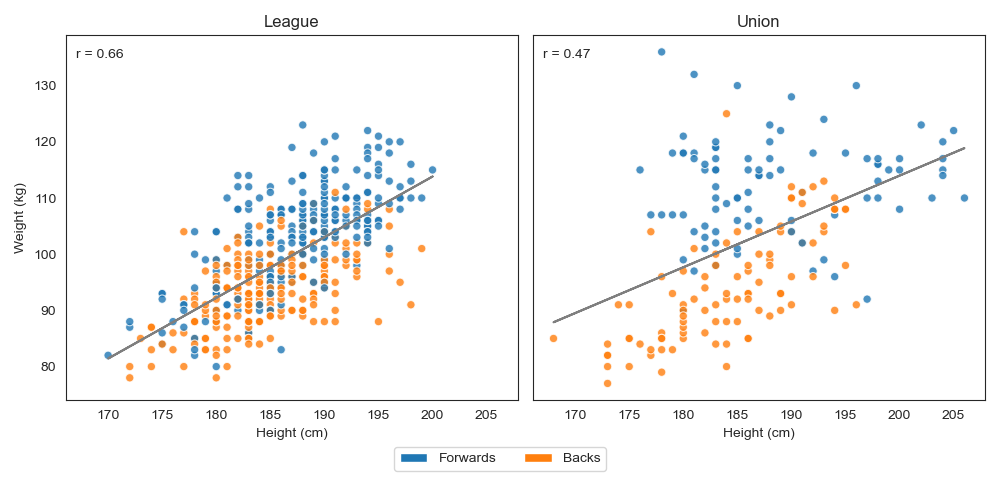

In [9]:
# Double scatter plot
sns.set_style('white')
sns.set_palette("tab10")
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5))

df_lg_mn = df_league[['height', 'weight', 'type']].dropna()
df_un_mn = df_union[['height', 'weight', 'type']].dropna()

sns.scatterplot(x='height', y='weight', data=df_lg_mn, ax=ax[0], alpha=0.8, hue='type')
sns.scatterplot(x='height', y='weight', data=df_un_mn, ax=ax[1], alpha=0.8, hue='type')

ax[0].set_title('League')
ax[1].set_title('Union')

ax[0].get_legend().remove()
ax[1].get_legend().remove()

ax[0].set_ylabel('Weight (kg)')
ax[0].set_xlabel('Height (cm)')
ax[1].set_xlabel('Height (cm)')

# League line of best fit
m, b = np.polyfit(df_lg_mn['height'], df_lg_mn['weight'], 1)
x = df_lg_mn['height']
ax[0].plot(x, m*x + b, color='#7f7f7f')
ax[0].text(167, 135, 'r = {:.2f}'.format(df_lg_mn['height'].corr(df_lg_mn['weight'])))

# Union line of best fit
m, b = np.polyfit(df_un_mn['height'], df_un_mn['weight'], 1)
x = df_un_mn['height']
ax[1].plot(x, m*x + b, color='#7f7f7f')
ax[1].text(167, 135, 'r = {:.2f}'.format(df_un_mn['height'].corr(df_un_mn['weight'])))

current_palette = sns.color_palette().as_hex()
custom_lines = [Patch(facecolor=current_palette[0], label='Forwards'),
                Patch(facecolor=current_palette[1], label='Backs')]    

leg = fig.legend(handles=custom_lines, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 0.12))

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.show()

As shown through Pearson's r score, the union dataset obviously has a far greater spread than the league dataset. The difference between forwards and backs is also more pronounced in union.

<IPython.core.display.Javascript object>


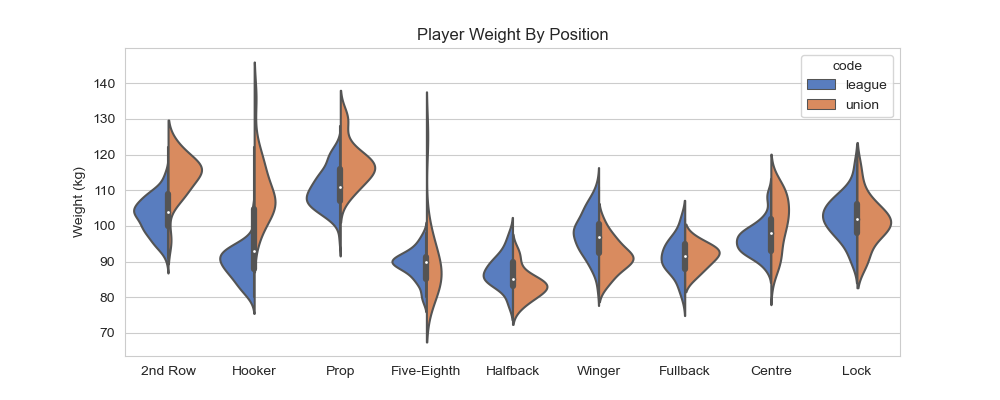

In [10]:
# Violin plot
sns.set_style('whitegrid')
plt.figure(figsize=(10, 4))

ax = sns.violinplot(x="position", y="weight", hue="code",
                    data=df_boxplots, palette="muted", split=True)

ax.set_title('Player Weight By Position')
ax.set_ylabel('Weight (kg)')
ax.set_xlabel('')

plt.show()

The weights of most positions between league and union are generally pretty similar, with a key difference being that the weights of union forwards tend to be a fair bit heavier. One position is very different though which is that of 'Hooker'. League hookers in this dataset tend to be far lighter than union hookers. The most likely explanation for this difference is that hookers in league and union play very different roles in that union hookers have to actually hook the ball in a scrum, whereas league hookers just play dummy half, resulting in far smaller hookers (Cameron Smith, Damien Cook etc.).

<IPython.core.display.Javascript object>


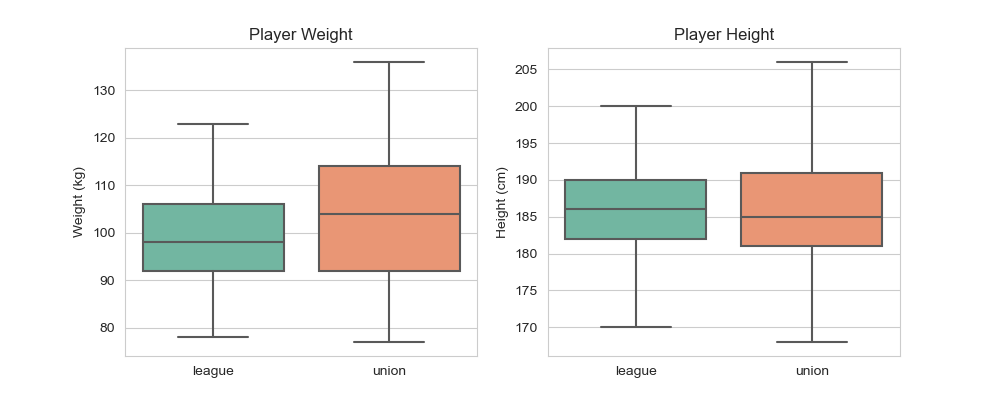

In [11]:
# Double box plot
sns.set_style('whitegrid')
sns.set_palette("Set2")
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(x='code', y='weight', data=df_boxplots, ax=ax[0])
sns.boxplot(x='code', y='height', data=df_boxplots, ax=ax[1])

ax[0].set_title('Player Weight')
ax[1].set_title('Player Height')

ax[0].set_ylabel('Weight (kg)')
ax[1].set_ylabel('Height (cm)')
ax[0].set_xlabel('')
ax[1].set_xlabel('')

fig.show()

Range and interquartile range for both weight and height are larger in union than in league.

<h3 style='color: #457b9d'>age</h3>

<IPython.core.display.Javascript object>


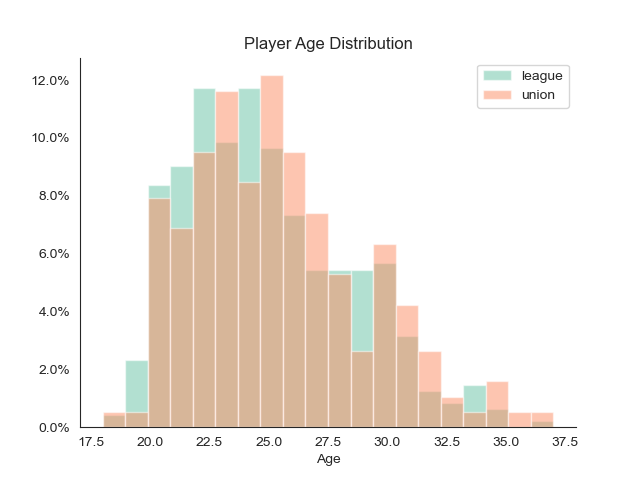

In [12]:
# Histogram
sns.set_style('white')
sns.set_palette("Set2")

fig, ax = plt.subplots()

data1 = df_league.age.dropna()
data2 = df_union.age.dropna()

ax.hist(data1, alpha=0.5, weights=np.ones(len(data1)) / len(data1), bins=20, label='league')
ax.hist(data2, alpha=0.5, weights=np.ones(len(data2)) / len(data2), bins=20, label='union')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('Player Age Distribution')
ax.set_xlabel('Age')

ax.legend()

fig.gca().yaxis.set_major_formatter(PercentFormatter(1))
fig.show()

Interestingly, the age distribution for both codes is remarkably similar, with a slightly higher concentration of youth in the NRL.

<h3 style='color: #457b9d'>state of origin</h3>

Due to less information being provided on the Super Rugby website than on the NRL website, the rest of this workbook will only be applicable to the NRL.

The following graph shows where NRL players come from, which overwhelmingly is NSW.

<IPython.core.display.Javascript object>


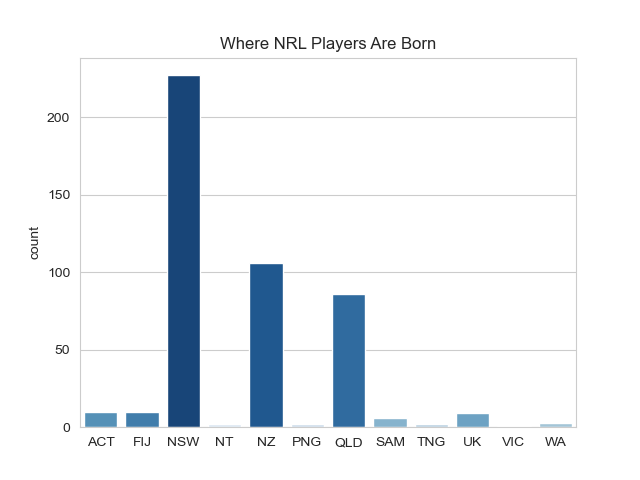

In [13]:
states = df_league[['birth_state', 'name']].dropna().groupby('birth_state').agg({'name': 'size'})
states = states.rename(columns={'name': 'count'})['count']

# Bar plot
sns.set_style('whitegrid')
plt.figure()
pal = sns.color_palette("Blues", len(states))
rank = states.argsort().argsort()
ax = sns.barplot(x=states.index, y=states, palette=np.array(pal[::])[rank])
ax.set_title('Where NRL Players Are Born')
ax.set_xlabel('')
plt.show()

In [14]:
# Clubs with the highest percentage of players from their own state

clubs_states = {'Broncos': 'QLD', 'Bulldogs': 'NSW', 'Cowboys': 'QLD', 'Dragons': 'NSW', 'Eels': 'NSW', 'Knights': 'NSW', 
               'Panthers': 'NSW', 'Rabbitohs': 'NSW', 'Raiders': 'ACT', 'Roosters': 'NSW', 'Sea Eagles': 'NSW', 
               'Sharks': 'NSW', 'Storm': 'VIC', 'Titans': 'QLD', 'Warriors': 'NZ', 'George': 'NSW'}

club_hometown_players = clubs_states

# Determining the percentage for each club
for club, state in clubs_states.items():
    club_hometown_players[club] = len(df_league[(df_league.current_team.str.contains(club)) & 
                                                (df_league.birth_state == state)])/len(df_league[df_league.current_team.str.contains(club)]['birth_state'].dropna())

col_name = '% of Players Born in Club State'    
df_hometown = pd.DataFrame(data=club_hometown_players.items(), columns=['Club', col_name]).sort_values(col_name, ascending=False)
df_hometown.index = np.arange(1, 17)
df_hometown

,Club,% of Players Born in Club State
1,Rabbitohs,0.718750
2,Sea Eagles,0.703704
3,Eels,0.642857
4,Dragons,0.625000
5,George,0.625000
6,Sharks,0.607143
7,Panthers,0.593750
8,Cowboys,0.562500
9,Roosters,0.560000
10,Knights,0.548387


The above table shows the percentage of players at each club who were born in the state where that club is located. Given that so many players come from NSW, it is not surprising that NSW clubs are at the top of the list. Similarly, it is not suprising the the Melbourne Storm have no players from Victoria, given that it is really just a transplant club aiming to grow the game in Victoria.

<h3 style='color: #457b9d'>experience</h3>

I find the following table interesting in that it shows that the experience of a team isn't always a good indicator of the success of the team. The Penrith Panthers are the least experienced team in the competition by a large margin and yet they have cemented their spot at the top of the ladder. In contrast, the Sydney Roosters are still in the running to win an historic three premierships in a row and their team is nearly twice as experienced as Penrith.

In [15]:
df_experience = df_league[['current_team', 'career_appearances']].dropna()
df_experience.groupby('current_team').agg('sum').sort_values('career_appearances')

# The following table shows the sum of total NRl games played by each player in each team

,career_appearances
current_team,
Penrith Panthers,1547.0
South Sydney Rabbitohs,1846.0
Manly-Warringah Sea Eagles,2008.0
Canterbury-Bankstown Bulldogs,2041.0
Cronulla-Sutherland Sharks,2059.0
New Zealand Warriors,2089.0
St. George Illawarra Dragons,2139.0
Gold Coast Titans,2156.0
Canberra Raiders,2227.0


<h3 style='color: #457b9d'>previous club</h3>

There has been a lot of talk recently about the value and rarity of one club players, with the argument being that players today are less loyal and are just chasing money. Adding weight to this argument is the fact that 45% of players in the NRL have played for another NRL club, as per below. Not a great statistic.

In [16]:
# Unique identifiers for each club. This tuple was formulated using a unique of list of previous clubs that appeared.
# St. George has become 'George' to avoid clashing with the Catalan Dragons.
prev_club_iden = ('Broncos', 'Raiders', 'Bulldogs', 'Sharks', 'Titans', 'Sea Eagles', 'Storm', 'New Zealand Warriors', 
                  'Knights', 'Cowboys', 'Eels', 'Panthers', 'George', 'Rabbitohs', 'Roosters', 'Wests Tigers')

# I have calculated cnt this way so that I exclude clubs in the UK and in rare cases, junior clubs
cnt = 0
for item in df_league.previous_club.dropna():
    for club in prev_club_iden:
        if club in item:
            cnt += 1
            break
            
# Proportion of NRL players who have played for another NRL club
cnt/len(df_league)

0.44664031620553357